# Introduction to CAD systems and image processing basic

Implementing basic image processing techniques and getting familiar with a few types of medical imaging data.

Data used:
- mammography (breast, 2D)
- histopathology (colon, 2D)
- chest CT (lungs, 3D)

Techniques covered:
- conversion of raw mammography data into a gray-scale image
- stain normalization in digital pathology with histogram matching
- trachea detection in chest CT with blob detection

In [1]:
%pip install -q --upgrade ismi_utils

In [2]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import SimpleITK as sitk
from matplotlib import cm
from scipy.ndimage import binary_fill_holes

from ismi_utils import download_data

from IPython.display import Image, display
import base64

## 1. Gray-scale transformation of breast tomography

Task:  Reconstruct a gray-scale mammography image from the raw data acquired with the mammography machine. The processed image can then be used by radiologists to detect tumors, masses, cysts and micro-calcifications.

Download publicly available data

In [3]:
download_data("data.zip", link="https://surfdrive.surf.nl/files/index.php/s/5675CTqWNfms8GS/download")

100%|██████████| 178M/178M [00:05<00:00, 32.6MB/s]


The downloaded folder should have the following structure:

```
assignment_1
  |-LIDC-IDRI
    |-LIDC-IDRI-0001
      |-1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178
        |-1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192
          |-000001.dcm
          |-...
  |-CRC-Prim-HE-05_APPLICATION.mha
  |-CRC-Prim-HE-10_APPLICATION.mha
  |-processed_mammography.mhd
  |-processed_mammography.raw
  |-raw_mammography.mhd
  |-raw_mammography.raw
  ```

In [4]:
# Raw and gray-level data in ITK format
raw_img_filename = "./assignment_1/raw_mammography.mhd"
out_img_filename = "./assignment_1/processed_mammography.mhd"

# Read ITK files using SimpleITK
raw_img = sitk.ReadImage(raw_img_filename)
out_img = sitk.ReadImage(out_img_filename)

# Print image information
print(f"image size: {raw_img.GetSize()}")
print(f"image origin: {raw_img.GetOrigin()}")
print(f"image spacing: {raw_img.GetSpacing()}")
print(f"image width: {raw_img.GetWidth()}")
print(f"image height: {raw_img.GetHeight()}")
print(f"image depth: {raw_img.GetDepth()}")

image size: (2560, 3328)
image origin: (0.0, 0.0)
image spacing: (0.07000000029802322, 0.07000000029802322)
image width: 2560
image height: 3328
image depth: 0


In [5]:
print(raw_img.GetSpacing()[0])
# Convert the ITK image into numpy format
out_np = sitk.GetArrayFromImage(out_img)
raw_np = sitk.GetArrayFromImage(raw_img)
print(type(out_np))
print(out_np.shape)

0.07000000029802322
<class 'numpy.ndarray'>
(3328, 2560)


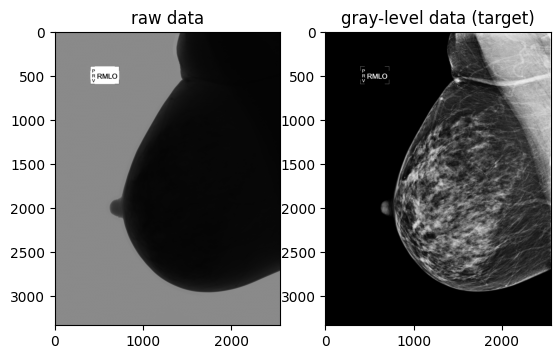

In [6]:
# Visualize the two numpy arrays
plt.subplot(1,2,1)
plt.imshow(raw_np, cmap="gray")
plt.title("raw data")
plt.subplot(1,2,2)
plt.imshow(out_np, cmap="gray")
plt.title("gray-level data (target)")
plt.show()

### Steps to convert the raw data image into the gray-level target image:
- Logaritmic transformation
- Intensity inversion
- Contrast stretching


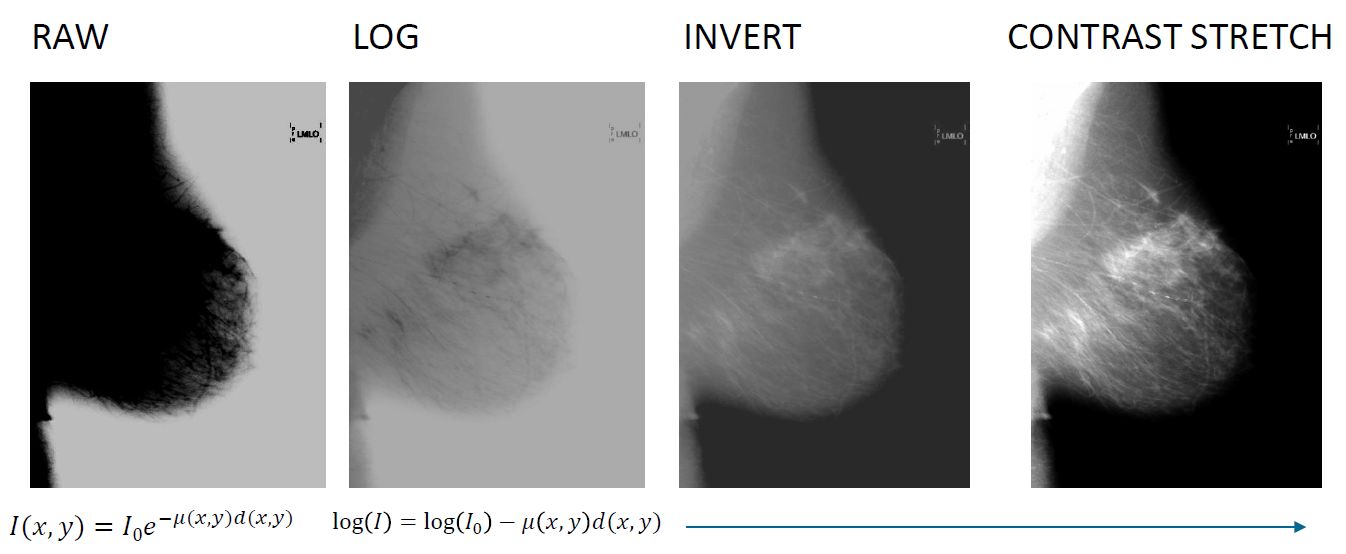

In [7]:
image_path = 'raw2gray.png'

try:
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode()

    markdown_code = f'<img src="data:image/png;base64,{encoded_string}" alt="raw2gray.png">'
    display(Image(url=f"data:image/png;base64,{encoded_string}", format='png'))

except FileNotFoundError:
    print(f"Error: File not found at '{image_path}'.")

In [8]:
# Logarithmic transformation
def log_transform(x):
    x = x + 1
    return np.log(x)

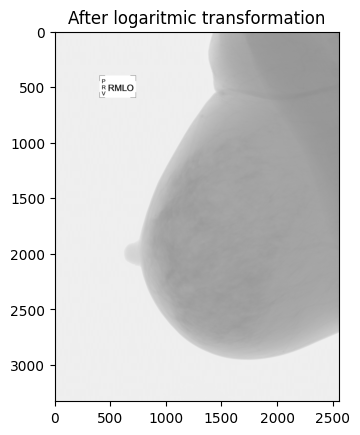

In [9]:
mammo_log = log_transform(raw_np)

plt.imshow(mammo_log, cmap="gray")
plt.title("After logaritmic transformation")
plt.show()

In [10]:
# Intensity inversion
def intensity_inversion(x):
    return np.max(x) - x

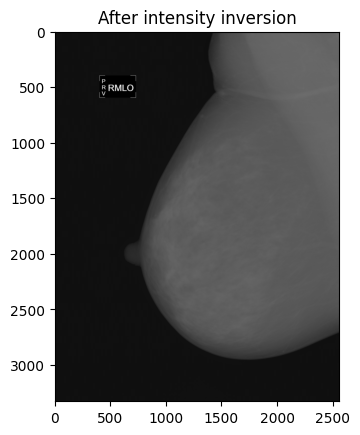

In [11]:
mammo_inv = intensity_inversion(mammo_log)

plt.imshow(mammo_inv, cmap="gray")
plt.title("After intensity inversion")
plt.show()

In order to apply the contrast stretching operation, we define a general contrast stretching function with inputs:
- the input signal
- the window range values p0 and pk

In [12]:
def contrast_stretching(x, p0, pk, q0=0., qk=255.):
    q =  q0 + (qk - q0) * ((x - p0)/(pk - p0))
    return np.clip(q, q0, qk)

Image type: float32
Max value in an image: 9.704060554504395


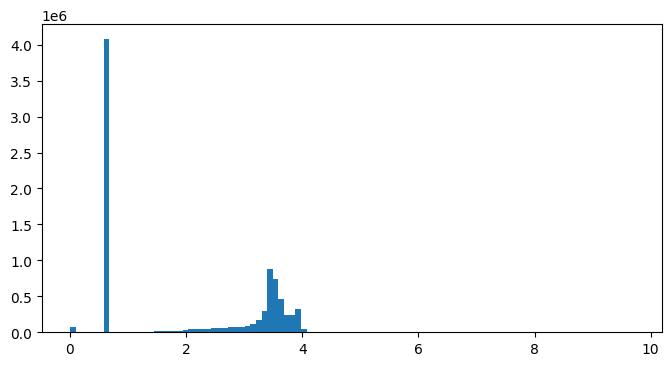

In [13]:
# Visualize histogram and pick appropriate p values
print(f"Image type: {mammo_inv.dtype}")
print(f"Max value in an image: {np.max(mammo_inv)}")
plt.figure(figsize=(8, 4))
plt.hist(mammo_inv.flatten(), 100)
plt.show()

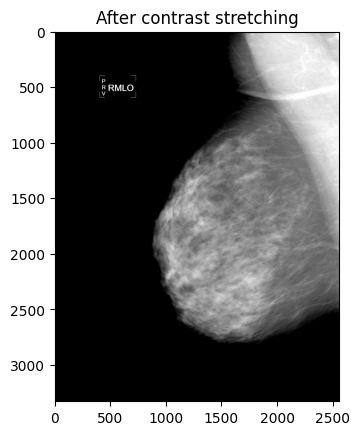

In [14]:
p0 = 3
pk = 4

mammo_cs = contrast_stretching(mammo_inv, p0, pk)
plt.imshow(mammo_cs, cmap="gray")
plt.title("After contrast stretching")
plt.show()

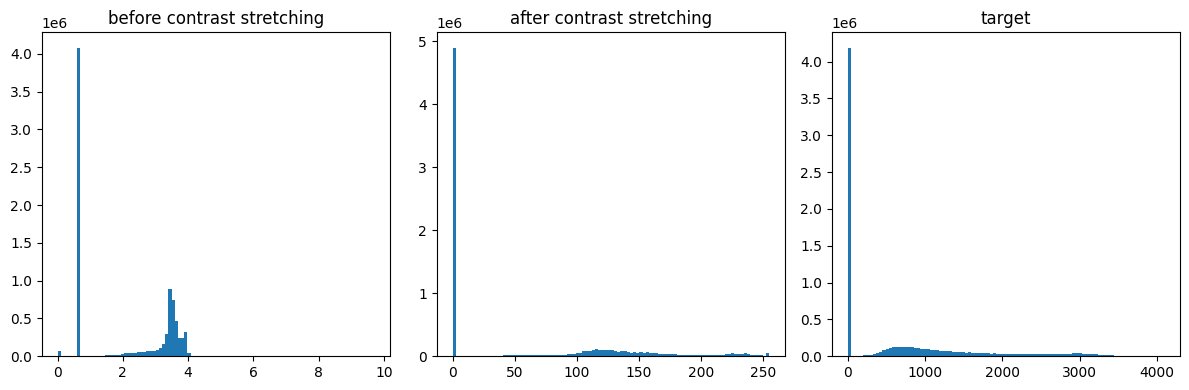

In [15]:
# Compare histograms of current image and target image
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.hist(mammo_inv.flatten(),100)
plt.title("before contrast stretching")
plt.subplot(1,3,2)
plt.hist(mammo_cs.flatten(),100)
plt.title("after contrast stretching")
plt.subplot(1,3,3)
plt.hist(out_np.flatten(),100)
plt.title("target")
plt.tight_layout()
plt.show()

## Histogram matching instead of contrast stretching

In this case we have the target image so we can perform histogram matching instead of contrast stretching and check if we can achieve a better result.

In [16]:
def get_histogram_matching_lut(h_input, h_template):
    """
    Calculates a look-up table for histogram matching

    Args:
      h_input: Input histogram
      h_template: Reference histogram

    Returns:
      LUT: Look-up table
      H_input: Cumulative distribution of h_input
      H_template: Cumulative distribution of h_template
    """

    if len(h_input) != len(h_template):
        raise ValueError("Histograms length mismatch!")
    n_bins = len(h_input)

    # Compute the cumulative distribution functions
    H_input = np.cumsum(h_input) / np.sum(h_input)
    H_template = np.cumsum(h_template) / np.sum(h_template)

    # Initialize the LUT
    LUT = np.zeros(n_bins, dtype=np.int32)

    # Build the LUT by finding the closest match for each value in H_input
    for i in range(n_bins):
        diff = np.abs(H_template - H_input[i])
        LUT[i] = np.argmin(diff)

    # normalize LUT (such that the histogram-matched image is normalized)
    LUT = LUT / n_bins

    return LUT, H_input, H_template

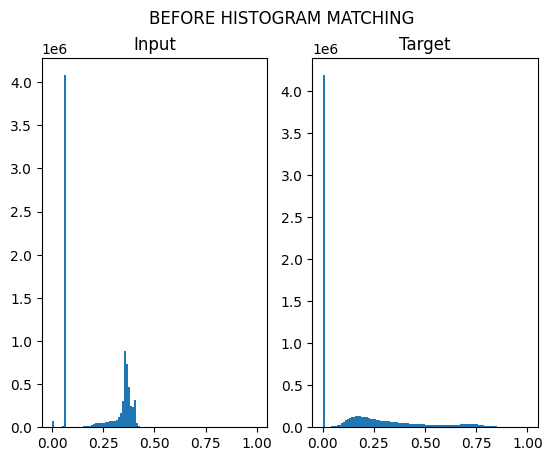

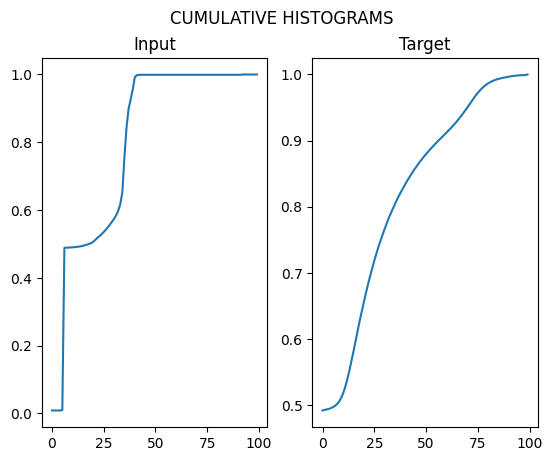

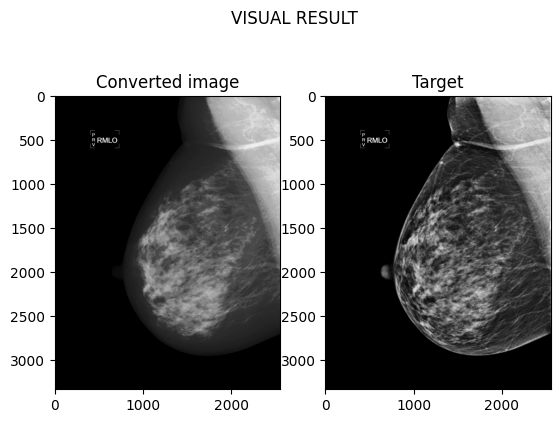

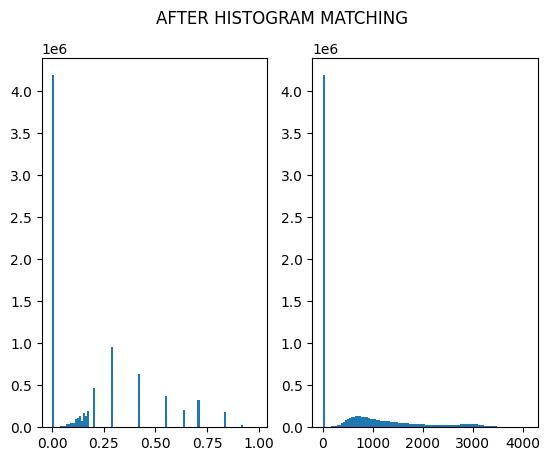

In [17]:
# Rescale images between [0,1]
out_np = out_np.astype(float)
mammo_inv_norm = (mammo_inv - mammo_inv.flatten().min())/(mammo_inv.flatten().max() - mammo_inv.flatten().min())
mammo_out_norm = (out_np - out_np.flatten().min())/(out_np.flatten().max() - out_np.flatten().min())

n_bins = 100 # Define the number of bins
hist_inv = np.histogram(mammo_inv_norm, bins=np.linspace(0., 1., n_bins+1))
hist_out = np.histogram(mammo_out_norm, bins=np.linspace(0., 1., n_bins+1))

# Compute LUT
LUT, H_input, H_template = get_histogram_matching_lut(hist_inv[0], hist_out[0])
assert(LUT        is not None),"LUT cannot be None"
assert(H_input    is not None),"H_input cannot be None"
assert(H_template is not None),"H_template cannot be None"

# Histograms before matching
plt.suptitle("BEFORE HISTOGRAM MATCHING")
plt.subplot(1, 2, 1); plt.hist(mammo_inv_norm.flatten(), 100)
plt.title("Input")
plt.subplot(1, 2, 2); plt.hist(mammo_out_norm.flatten(), 100)
plt.title("Target")
plt.show()

# Plot cumulative histogram
plt.suptitle("CUMULATIVE HISTOGRAMS")
plt.subplot(1, 2, 1); plt.plot(H_input)
plt.title("Input")
plt.subplot(1, 2, 2); plt.plot(H_template)
plt.title("Target")
plt.show()

# Apply histogram matching
mammo_lut = LUT[(mammo_inv_norm * (n_bins-1)).astype(int)]
mammo_lut = mammo_lut.squeeze()

# Visual result
plt.suptitle("VISUAL RESULT")
plt.subplot(1, 2, 1); plt.imshow(mammo_lut, cmap="gray")
plt.title("Converted image")
plt.subplot(1, 2, 2); plt.imshow(out_np, cmap="gray")
plt.title("Target")
plt.show()

# histograms after matching
plt.suptitle("AFTER HISTOGRAM MATCHING")
plt.subplot(1, 2, 1)
plt.hist(mammo_lut.flatten(), 100)
plt.subplot(1, 2, 2)
plt.hist(out_np.flatten(), 100)
plt.show()

## 2. Stain normalization with histogram matching

Task: Apply histogram matching with the aim of normalizing the variability of stain across digital pathology images.

Context: In pathology, tissue samples are cut and stained with specific dyes in order to enhance some tissues that are relevant for the diagnosis. The most commonly used staining is called Hematoxylyn and Eosin (H&E), which is routinely applied for diagnostic purposes. The problem with H&E is that there is a large variability of stain across laboratories, and even in the same laboratory, when staining is done in different days of the week. This is because the final result strongly depends on the type and the density of the dyes and on the time the tissue is actually exposed to the dye.

(5000, 5000, 3)
(5000, 5000, 3)


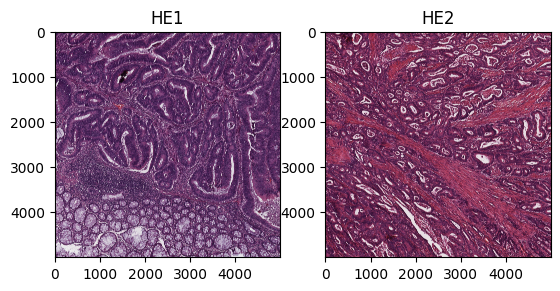

In [18]:
# load data
HE1 = sitk.GetArrayFromImage(sitk.ReadImage("./assignment_1/CRC-Prim-HE-05_APPLICATION.mha"))
HE2 = sitk.GetArrayFromImage(sitk.ReadImage("./assignment_1/CRC-Prim-HE-10_APPLICATION.mha"))

print(HE1.shape)
print(HE2.shape)

plt.subplot(1, 2, 1); plt.imshow(HE1); plt.title("HE1")
plt.subplot(1, 2, 2); plt.imshow(HE2); plt.title("HE2")
plt.show()

In [19]:
# Implement a stain normalization function based on histogram matching
def stain_normalization(input_img, target_img, n_bins=100):
    """ Stain normalization based on histogram matching."""
    # normalize to 0-1 range
    input_img = input_img/255.
    target_img = target_img/255.

    stain_norm_img = np.zeros_like(input_img, dtype=np.float32)

    for channel in range(input_img.shape[-1]):
        # Flatten the channel
        src_vals = input_img[..., channel].flatten()
        tmpl_vals = target_img[..., channel].flatten()

        # Compute histograms and cumulative distributions
        src_hist, bin_edges = np.histogram(src_vals, bins=n_bins, range=(0, 1), density=True)
        tmpl_hist, _ = np.histogram(tmpl_vals, bins=n_bins, range=(0, 1), density=True)

        src_cdf = np.cumsum(src_hist)
        tmpl_cdf = np.cumsum(tmpl_hist)

        # Normalize the CDFs
        src_cdf = src_cdf / src_cdf[-1]
        tmpl_cdf = tmpl_cdf / tmpl_cdf[-1]

        # Create mapping using linear interpolation
        interp_values = np.interp(src_cdf, tmpl_cdf, bin_edges[:-1])

        # Map source values to target values
        stain_norm_img[..., channel] = np.interp(src_vals, bin_edges[:-1], interp_values).reshape(input_img.shape[:-1])

    # convert back to uint8 range
    stain_norm_img = (255.0*stain_norm_img).astype(np.uint8)
    return stain_norm_img

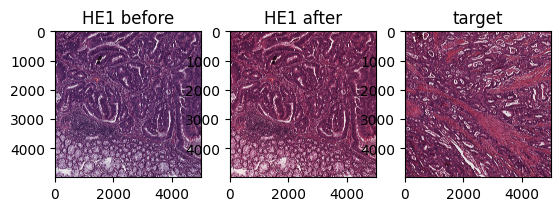

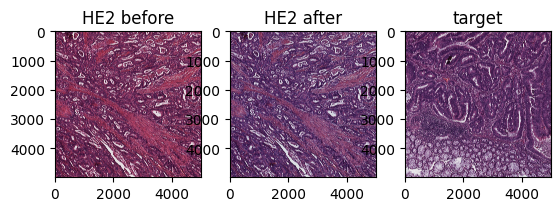

In [20]:
# Transform HE1 to match HE2
HE1_norm = stain_normalization(HE1, HE2);
assert(HE1_norm is not None),"HE1_norm cannot be None"

plt.subplot(1,3,1)
plt.imshow(HE1); plt.title("HE1 before")
plt.subplot(1,3,2)
plt.imshow(HE1_norm); plt.title("HE1 after")
plt.subplot(1,3,3)
plt.imshow(HE2); plt.title("target")
plt.show()

# Transform HE2 to match HE1
HE2_norm = stain_normalization(HE2, HE1);
plt.subplot(1,3,1); plt.imshow(HE2)
plt.title("HE2 before")
plt.subplot(1,3,2); plt.imshow(HE2_norm)
plt.title("HE2 after")
plt.subplot(1,3,3); plt.imshow(HE1)
plt.title("target")
plt.show()

## 3. Trachea detection in chest CT

Task: Develop a blob detector and process all slides of a given scan. Implement an algorithm that reads an entire CT scan and returns the coordinates (x,y,z) of a point inside the trachea.

 Make use of the publicly available dataset LIDC-IDRI: https://www.cancerimagingarchive.net/collection/lidc-idri/

 For more context on CT scans and the anatomy of the chest see:
- https://w-radiology.com/chest_ct/
- https://w-radiology.com/chest_ct-parenchyma/

In [21]:
# Load the first scan from LIDC-IDRI
scan_path = "./assignment_1/LIDC-IDRI/LIDC-IDRI-0001/1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192"

# Read all dicom files in the folder
reader = sitk.ImageSeriesReader()
dicom_slice_paths = reader.GetGDCMSeriesFileNames(scan_path)
reader.SetFileNames(dicom_slice_paths)
image = reader.Execute()

# Convert the slice to a numpy array
ct_slice_numpy = sitk.GetArrayFromImage(image)
dims = image.GetSize()

# Print scan information
print(f"Found {len(dicom_slice_paths)} dicom files, resulting in an image of dimension {dims}")

# Convert to numpy arrays for convenience
scan = sitk.GetArrayFromImage(image)
print(scan.shape)

Found 133 dicom files, resulting in an image of dimension (512, 512, 133)
(133, 512, 512)


Create a blob detector based on a Gaussian function. Create a Gaussian kernel in 2D, given a value for sigma in millimiters. Ensure the kernel size is 3 sigma - i.e. both x and y range from -3 to +3 sigma.

In [22]:
def gaussian_2d(sigma_mm, voxel_size):
    """
    Makes a 2D Gaussian kernel.

    Args:
    sigma_mm: sigma in mm
    voxel_size: the size of a voxel in mm

    Returns:
    kernel: kernel
    x : matrix of x coordinates of the filter
    y : matrix of y coordinates of the filter
    """
    sigma_x_px = sigma_mm / voxel_size[0]  # Convert sigma from mm to pixels
    sigma_y_px = sigma_mm / voxel_size[1]

    # Compute kernel size (rounded up to ensure -3σ to +3σ fits)
    kx = int(np.ceil(3 * sigma_x_px))
    ky = int(np.ceil(3 * sigma_y_px))
    kernel_size_x = 2 * kx + 1
    kernel_size_y = 2 * ky + 1

    # Create coordinate grid
    x = np.linspace(-kx, kx, kernel_size_x)
    y = np.linspace(-ky, ky, kernel_size_y)
    X, Y = np.meshgrid(x, y)

    # Compute 2D Gaussian function
    normalization = 1 / (2 * np.pi * sigma_x_px * sigma_y_px)
    kernel = normalization * np.exp(-((X**2 / (2 * sigma_x_px**2)) + (Y**2 / (2 * sigma_y_px**2))))

    return kernel, X, Y

In [23]:
def laplacian_of_gaussian(g):
    """
    Compute the Laplacian of Gaussian

    Args:
    g : 2d numpy array

    Returns:
    LoG : 2d numpy array
    gxx : 2d numpy array
        Second partial derivative of g to x
    gyy : 2d numpy array
        Second partial derivative of g to y
    """

    # Compute the first derivatives
    gx, gy = np.gradient(g)

    # Compute the second derivatives (gxx and gyy)
    gxx, _ = np.gradient(gx)
    _, gyy = np.gradient(gy)

    # Compute the Laplacian (LoG)
    LoG = gxx + gyy

    return LoG,gxx,gyy

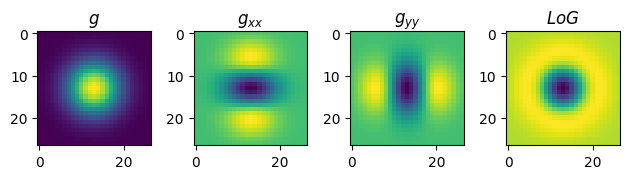

In [24]:
# Compute LoG
g,x,y = gaussian_2d(3.0, [0.7, 0.7])

LoG,gxx,gyy = laplacian_of_gaussian(g)

#visualize the filters
plt.subplot(1,4,1)
plt.imshow(g)
plt.title(r"$g$")
plt.subplot(1,4,2)
plt.imshow(gxx)
plt.title(r"$g_{xx}$")
plt.subplot(1,4,3)
plt.imshow(gyy)
plt.title(r"$g_{yy}$")
plt.subplot(1,4,4)
plt.imshow(LoG)
plt.title(r"$LoG$")
plt.tight_layout()
plt.show()

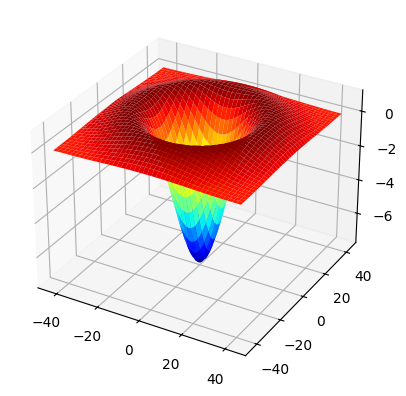

In [25]:
# Filter surface visualization
g,x,y = gaussian_2d(10.0, [0.7, 0.7])
LoG,gxx,gyy = laplacian_of_gaussian(g)
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
surf = ax.plot_surface(x, y, LoG, antialiased=True, cmap=cm.jet, linewidth=0)
plt.show()

In [26]:
# Function to get the area of the thorax
def get_body(ct_slice_numpy):
    thorax = (ct_slice_numpy > -524)
    thorax = binary_fill_holes(thorax)
    label, num_label = scipy.ndimage.label(thorax)
    size = np.bincount(label.ravel())
    biggest_label = size[1:].argmax() + 1
    thorax = (label == biggest_label)
    return thorax

In [27]:
def find_seed_point(scan):
    """
    Find a point inside the trachea

    Args:
    scan: 3D numpy array

    Returns:
    seed_point: tuple (x,y,z)
    """

    z_dim, h_dim, w_dim = scan.shape

    # sigmas = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
    sigmas = [6.0]
    num_sigmas = len(sigmas)

    max_responses = np.zeros((num_sigmas, z_dim, h_dim, w_dim), dtype=np.float32)

    for i, sigma in enumerate(sigmas):
        g, _, _ = gaussian_2d(sigma, [0.7, 0.7])
        LoG, _, _ = laplacian_of_gaussian(g)

        for slice_index in range(scan.shape[0]):
            image = scan[slice_index, :, :]
            body_mask = get_body(image)

            image[~body_mask] = 0

            image_fft = np.fft.fft2(image)
            LoG_fft = np.fft.fft2(LoG, s=image.shape)

            LoG_response = np.fft.ifft2(image_fft * LoG_fft)

            max_responses[i, slice_index, :, :] = np.minimum(max_responses[i, slice_index, :, :], np.real(LoG_response))

    averaged_responses = np.mean(max_responses, axis=0)

    z, y, x = np.unravel_index(np.argmin(averaged_responses), averaged_responses.shape)

    print(f"Trachea seed point found at: x={x}, y={y}, z={z}")

    return (x, y, z)

Trachea seed point found at: x=236, y=255, z=97


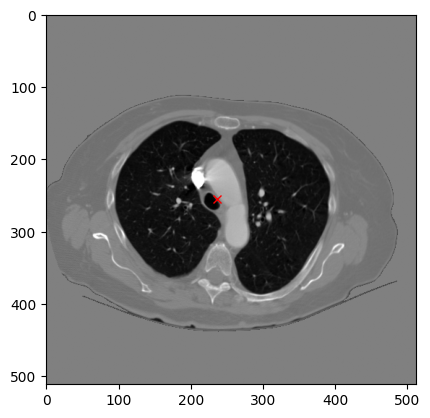

In [28]:
seed_point = find_seed_point(scan)

plt.figure()
plt.imshow(scan[seed_point[2], :, :], vmin=-1024.0, vmax=1024.0, cmap="gray")
plt.plot(seed_point[0], seed_point[1], "rx")
plt.show()